In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from h3 import h3 
from shapely.geometry import shape
from shapely.geometry import Point

In [2]:
df=pd.read_csv('taxi_essentials.csv', parse_dates=['Trip Start Timestamp','Trip End Timestamp'])
df=df.drop('Unnamed: 0',axis=1)
df['Trips Total']=df[['Fare','Tips','Tolls','Extras']].sum(axis=1)

In [3]:
#kann man ausfuerhren, muss man aber nicht
df['dur_min']=df['Trip Seconds'].apply(lambda x:round(x/60,2))

In [4]:
#communities vom chicago city portal heruntergeladen und hier jetzt einlesen
communities_gdf=gpd.read_file('extra_dataframes/Community Areas (current).geojson')

In [5]:
#df mit nur pickup und drop off location
look=df[['Pickup Centroid Latitude','Pickup Centroid Longitude','Dropoff Centroid Latitude','Dropoff Centroid Longitude']]
look=look.rename(columns={'Dropoff Centroid Latitude': 'dlat','Dropoff Centroid Longitude': 'dlong'})
look=look.rename(columns={'Pickup Centroid Latitude': 'plat','Pickup Centroid Longitude': 'plong'})
look

,plat,plong,dlat,dlong
0,41.884987,-87.620993,41.929047,-87.651311
1,41.938666,-87.711211,41.938666,-87.711211
2,41.980264,-87.913625,41.899602,-87.633308
3,41.792592,-87.769615,41.944227,-87.655998
4,41.884987,-87.620993,41.895033,-87.619711
...,...,...,...,...
5160231,41.871016,-87.631407,41.785999,-87.750934
5160232,41.884987,-87.620993,41.885281,-87.657233
5160233,41.922686,-87.649489,41.944227,-87.655998
5160234,41.892508,-87.626215,41.893216,-87.637844


In [6]:
#kreirt ein geopandas dataframe
geographical_dropoff_gdf=gpd.GeoDataFrame(look[['dlong','dlat']], geometry=gpd.points_from_xy(look.dlong, look.dlat))

#sucht nach den dropoff communites der jeweiligen dropoff location, quasi ein merge, wenn die location innerhalb
#(within) einer community ist
matched_drop_comm_gdf = gpd.sjoin(geographical_dropoff_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')

/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-6-bd342c627710>:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_drop_comm_gdf = gpd.sjoin(geographical_dropoff_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')


In [7]:
matched_drop_comm_gdf.fillna(10,inplace=True)
#hier fuelle ich nun die daten in df. also die 14.983 fehlenden dropoff communitys
df.loc[matched_drop_comm_gdf.index,'Dropoff Community Area']=matched_drop_comm_gdf['area_num_1']

In [8]:
#kreirt ein geopandas dataframe
geographical_pickup_gdf=gpd.GeoDataFrame(look[['plong','plat']], geometry=gpd.points_from_xy(look.plong, look.plat))
#sucht nach den Pickup communites der jeweiligen Pickup location, quasi ein merge, wenn die location innerhalb
#(within) einer community ist
matched_pick_comm_gdf = gpd.sjoin(geographical_pickup_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')

/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-8-fbf873aadb86>:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_pick_comm_gdf = gpd.sjoin(geographical_pickup_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')


In [9]:
matched_pick_comm_gdf['area_num_1'].fillna(10,inplace=True)
#hier fuelle ich nun die daten in df. also die 162 fehlenden pickup communitys
df.loc[matched_pick_comm_gdf.index,'Pickup Community Area']=matched_pick_comm_gdf['area_num_1']

In [10]:
#nun das gleiche mit pickup und drop off cencus tract machen:
census=gpd.read_file('extra_dataframes/Census Tracts - 2010.geojson')

In [11]:
#geodrop = dropoffdata fuer den census tract dropoff
geodrop_gdf = gpd.GeoDataFrame(look, geometry=gpd.points_from_xy(look.dlong, look.dlat))
matched_gdf = gpd.sjoin(geodrop_gdf, census[['geoid10','geometry']], how='left', op='within')

/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-11-fb201ae4c96f>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_gdf = gpd.sjoin(geodrop_gdf, census[['geoid10','geometry']], how='left', op='within')


In [12]:
#17031770700 is der census trac, der in dem datensatz census fehlt, und in dem sie eigentlich sind
#17031980000 is der census trac von chicago ohare, zu dem die dropoffs quasi zaehlen...
matched_gdf['geoid10'].fillna(17031770700, inplace=True)

#jetzt kann ich uebertragen
df.loc[:,'Dropoff Census Tract']=matched_gdf['geoid10']

In [13]:
#geopick = pickupdata fuer den census tract pickup
geopick_gdf = gpd.GeoDataFrame(look, geometry=gpd.points_from_xy(look.plong, look.plat))
matched_gdf = gpd.sjoin(geopick_gdf, census[['geoid10','geometry']], how='left', op='within')

/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-13-37a7629ca517>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_gdf = gpd.sjoin(geopick_gdf, census[['geoid10','geometry']], how='left', op='within')


In [14]:
#nun also die fehlenden werte auffuellen mit 17031770700
matched_gdf['geoid10'].fillna(17031770700, inplace=True)

In [15]:
#jetzt kann ich uebertragen
df.loc[:,'Pickup Census Tract']=matched_gdf['geoid10']

In [33]:
#wetterdatensatzladen
weather_df=pd.read_csv('extra_dataframes/weather_clean_final.csv',parse_dates=['date_time'])
weather_df=weather_df.drop('Unnamed: 0',axis=1)

In [17]:
# hier die timestamps abbrunden um gleich zusammenzufuehren
#also den datensatz ein bissche erweitern
weather_df.loc[:,'hour']=weather_df['date_time'].apply(lambda h :h.hour)
weather_df.loc[:,'day']=weather_df['date_time'].apply(lambda d :d.day)
weather_df.loc[:,'month']=weather_df['date_time'].apply(lambda m :m.month)

In [18]:
#hier soll gemerged werden, einmal werden die wetterdaten pro trip dazugeholt, dafuer hier
#erstmal neue columns erstellen mit der abgerundeten zeiten(stunde/monat/ etc)
#auch fuer spaetere analysen wichtig
df['date']=df['Trip Start Timestamp'].apply(lambda d: pd.to_datetime(d).floor('d'))
df['s_hour']=df['Trip Start Timestamp'].apply(lambda h: h.hour)
df['s_day']=df['Trip Start Timestamp'].apply(lambda d: d.day)
df['weekday']=df['Trip Start Timestamp'].apply(lambda w: w.dayofweek)
df['s_month']=df['Trip Start Timestamp'].apply(lambda m: m.month)

In [19]:
df=df.merge(weather_df[['avg_temp','precip','hour','day','month']],how='left',left_on=['s_hour','s_day','s_month'],right_on=['hour','day','month'])
df

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Fare,Tips,Tolls,Extras,Payment Type,Company,...,date,s_hour,s_day,weekday,s_month,avg_temp,precip,hour,day,month
0,2017-05-12 21:00:00,2017-05-12 21:15:00,865.0,4.6,15.00,2.55,0.0,2.0,Credit Card,American United,...,2017-05-12,21,12,4,5,21.1,0.0,21,12,5
1,2017-04-27 11:30:00,2017-04-27 11:30:00,20.0,0.0,3.25,0.65,0.0,1.0,Credit Card,American United,...,2017-04-27,11,27,3,4,14.4,1.0,11,27,4
2,2017-06-29 01:00:00,2017-06-29 01:15:00,1560.0,17.1,33.65,0.00,0.0,2.0,Cash,Choice Taxi Association,...,2017-06-29,1,29,3,6,25.6,0.0,1,29,6
3,2017-04-27 21:00:00,2017-04-27 21:30:00,2082.0,18.2,45.75,7.46,0.0,4.0,Credit Card,American United,...,2017-04-27,21,27,3,4,7.8,0.0,21,27,4
4,2017-05-03 14:15:00,2017-05-03 14:15:00,474.0,0.9,6.25,1.00,0.0,0.0,Credit Card,American United,...,2017-05-03,14,3,2,5,9.4,0.0,14,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160231,2017-10-08 16:30:00,2017-10-08 17:45:00,4260.0,28.5,72.25,0.00,0.0,0.0,Dispute,Choice Taxi Association,...,2017-10-08,16,8,6,10,20.6,0.0,16,8,10
5160232,2017-10-22 18:00:00,2017-10-22 18:15:00,540.0,0.0,7.25,1.65,0.0,1.0,Credit Card,Blue Ribbon Taxi Association Inc.,...,2017-10-22,18,22,6,10,20.0,0.0,18,22,10
5160233,2017-10-23 11:15:00,2017-10-23 11:15:00,360.0,0.0,6.00,3.00,0.0,0.0,Credit Card,Blue Ribbon Taxi Association Inc.,...,2017-10-23,11,23,0,10,10.6,1.0,11,23,10
5160234,2017-10-07 13:45:00,2017-10-07 14:00:00,900.0,3.1,12.25,2.65,0.0,1.0,Credit Card,Star North Management LLC,...,2017-10-07,13,7,5,10,20.0,0.0,13,7,10


In [20]:
#doppelte zeiten brauchen wir nicht
df.drop(['s_hour','s_day','s_month'],axis=1, inplace=True)

In [21]:
df.count()

Trip Start Timestamp          5160236
Trip End Timestamp            5160236
Trip Seconds                  5160236
Trip Miles                    5160236
Fare                          5160236
Tips                          5160236
Tolls                         5160236
Extras                        5160236
Payment Type                  5160236
Company                       5160236
Pickup Centroid Latitude      5160236
Pickup Centroid Longitude     5160236
Dropoff Centroid Latitude     5160236
Dropoff Centroid Longitude    5160236
new_TaxiID                    5160236
Trips Total                   5160236
dur_min                       5160236
Dropoff Community Area        5160236
Pickup Community Area         5160236
Dropoff Census Tract          5160236
Pickup Census Tract           5160236
date                          5160236
weekday                       5160236
avg_temp                      5160236
precip                        5160236
hour                          5160236
day         

In [26]:
#das kann man auskommentieren und einmal laufen lassen
#df.to_csv('taxi_complete.csv')

# ab hier ist df jetzt vollständig

## hier ist ein part mit H3, den ich noch nicht komplett verstehe warum wir das brauchen sollten wenn wir schon community area und census tracts haben

In [27]:
H3_HEXAGON_RESOLUTION = 8

In [28]:
df["h3_hex_id_start"] = df.apply(lambda row: h3.geo_to_h3(row["Pickup Centroid Latitude"], row["Pickup Centroid Longitude"], H3_HEXAGON_RESOLUTION) if (row['Pickup Centroid Latitude'] and row['Pickup Centroid Longitude']) else 0, axis=1)
# trips["h3_hex_id_end"] = trips.apply(lambda row: h3.geo_to_h3(row["latitude_start"], row["longitude_end"], H3_HEXAGON_RESOLUTION) if (row['latitude_end'] and row['longitude_end']) else 0, axis=1)

trips_starts = pd.DataFrame()
trips_starts = df.groupby('h3_hex_id_start').count()['dur_min'].reset_index().rename(columns={'dur_min': 'count'})
trips_starts['geometry'] = trips_starts.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_hex_id_start"], geo_json=True)), axis=1)

trips_starts_geo = gpd.GeoDataFrame(trips_starts, geometry=trips_starts['geometry'], crs='EPSG:4326')

In [29]:
trips_starts

,h3_hex_id_start,count,geometry
0,8826641915fffff,27,POLYGON ((-87.54296487952223 41.66656964617557...
1,882664194bfffff,1,POLYGON ((-87.53235897403569 41.70084757190684...
2,8826641961fffff,307,POLYGON ((-87.57319298911698 41.69756072286854...
3,8826641b23fffff,35,POLYGON ((-87.53039023937232 41.71477318428209...
4,882664520bfffff,22987,POLYGON ((-87.76679108859273 41.79984486289543...
...,...,...,...
262,8827593699fffff,1502,POLYGON ((-87.80404417594646 41.99391889040945...
263,88275936b1fffff,40,POLYGON ((-87.84030498230973 41.98301332953332...
264,88275936b7fffff,1,POLYGON ((-87.84697425084084 41.97653768691125...
265,88275936bbfffff,1,POLYGON ((-87.82885003687991 41.98199202793128...


<AxesSubplot:>

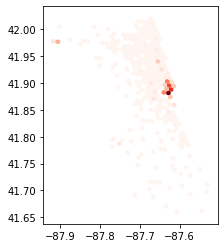

In [30]:
trips_starts_geo.plot(column='count', cmap='Reds')